In [4]:
import csv
import pandas as pd
import sklearn.model_selection as skm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

## Loading data

We use a subset of the *Yelp reviews* dataset: each short text is accompanied with a sentiment label (0 -- negative, 1 -- positive).

In [5]:
data = pd.read_csv('yelp_labelled.txt', header=None, sep='\t')
data.head(5)

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Data preparation
We split the data into train and test subsets and transform texts into vectors.

In [6]:
X_text = data[0]
y = data[1]
X_text_train, X_text_test, y_train, y_test = skm.train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=42)
vectorizer = CountVectorizer(min_df=1, stop_words="english", binary=False, lowercase=True)
X_train = vectorizer.fit_transform(X_text_train)
X_test = vectorizer.transform(X_text_test)
print('Vocabulary size: ', X_train.shape[1])

Vocabulary size:  1570


## Training and testing

We fit a multinomial naive Bayes classifier and test it.

In [7]:
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)
print('Test set accuracy: %.3f' % accuracy_score(y_test, clf.predict(X_test)))

Test set accuracy: 0.815


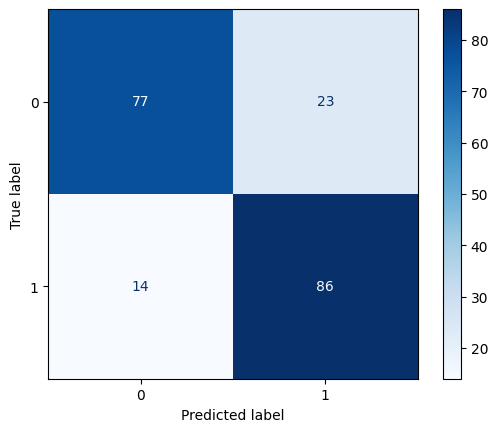

In [8]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )

In [9]:
X_text_train_new, X_text_val, y_train_new, y_val = skm.train_test_split(X_text_train, y_train, test_size=0.125, stratify=y_train, random_state=42)
X_train_new = vectorizer.fit_transform(X_text_train_new)
X_val = vectorizer.transform(X_text_val)
X_test = vectorizer.transform(X_text_test)

In [10]:
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train_new, y_train_new)
print('Test set accuracy: %.3f' % accuracy_score(y_test, clf.predict(X_test)))
print('Validation set accuracy: %.3f' % accuracy_score(y_val, clf.predict(X_val)))

Test set accuracy: 0.810
Validation set accuracy: 0.690


In [11]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 31.3 MB/s eta 0:00:00


In [12]:
import stanza

stanza.download('en')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
nlp = stanza.Pipeline('en', processors='tokenize,lemma', tokenize_no_ssplit=True)

lemmatized_texts = []
for text in X_text:
  doc = nlp(text)
  lemmatized_texts.append(' '.join([word.lemma for sentence in doc.sentences for word in sentence.words]))

data['lemmatized_text'] = lemmatized_texts

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [15]:
X_text_train, X_text_test, y_train, y_test = skm.train_test_split(data['lemmatized_text'], y, test_size=0.2, stratify=y, random_state=0)
X_text_train_new, X_text_val, y_train_new, y_val = skm.train_test_split(X_text_train, y_train, test_size=0.125, stratify=y_train, random_state=0)

In [18]:
params = [
    {"min_df": 1, "stop_words": "english", "binary": False, "lowercase": True},
    {"min_df": 5, "stop_words": "english", "binary": False, "lowercase": True},
    {"min_df": 1, "stop_words": None, "binary": True, "lowercase": False},
    {"min_df": 5, "stop_words": None, "binary": True, "lowercase": False}
]
val_acc_best = 0
vectorizer_best = None

for param in params:
    vectorizer = CountVectorizer(**param)
    X_train_new = vectorizer.fit_transform(X_text_train_new)
    X_val = vectorizer.transform(X_text_val)

    clf = MultinomialNB(alpha=1.0)
    clf.fit(X_train_new, y_train_new)
    current_val_acc = accuracy_score(y_val, clf.predict(X_val))
    print(f'Parameter: {param}, validation set accuracy: {current_val_acc:.3f}')

    if current_val_acc > val_acc_best:
        val_acc_best = current_val_acc
        vectorizer_best = vectorizer

print(f'\nBest vectorizer parameters: {vectorizer_best.get_params()}')

Parameter: {'min_df': 1, 'stop_words': 'english', 'binary': False, 'lowercase': True}, validation set accuracy: 0.800
Parameter: {'min_df': 5, 'stop_words': 'english', 'binary': False, 'lowercase': True}, validation set accuracy: 0.670
Parameter: {'min_df': 1, 'stop_words': None, 'binary': True, 'lowercase': False}, validation set accuracy: 0.820
Parameter: {'min_df': 5, 'stop_words': None, 'binary': True, 'lowercase': False}, validation set accuracy: 0.690

Best vectorizer parameters: {'analyzer': 'word', 'binary': True, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': False, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}


In [19]:
X_train_new = vectorizer_best.fit_transform(X_text_train_new)
X_test = vectorizer_best.transform(X_text_test)
clf.fit(X_train_new, y_train_new)
test_accuracy = accuracy_score(y_test, clf.predict(X_test)) # apply to the test set with best params
print(f'Best CountVectorizer test set accuracy: {test_accuracy:.3f}')

Best CountVectorizer test set accuracy: 0.810


TfidfVectorizer
Validation set accuracy: 0.790, test set accuracy: 0.790


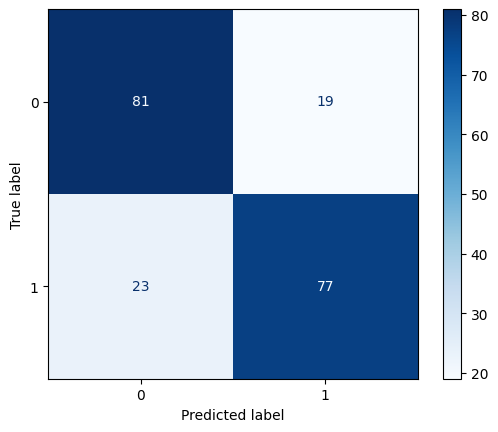

In [21]:
vectorizer = TfidfVectorizer(min_df=1, stop_words="english", binary=False, lowercase=True)
X_train_new = vectorizer.fit_transform(X_text_train_new)
X_val = vectorizer.transform(X_text_val)
X_test = vectorizer.transform(X_text_test)

clf.fit(X_train_new, y_train_new)
val_accuracy = accuracy_score(y_val, clf.predict(X_val))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f'TfidfVectorizer\nValidation set accuracy: {val_accuracy:.3f}, test set accuracy: {test_accuracy:.3f}')

# Display the confusion matrix for the best vectorizer
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
)
plt.show()

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

params = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_text_train_new, y_train_new)

print("Best params: ", grid_search.best_params_)
print("Best CV score: {:.2f}".format(grid_search.best_score_))

X_val = grid_search.best_estimator_.named_steps['tfidf'].transform(X_text_val)
clf = grid_search.best_estimator_.named_steps['clf']

print(f'\nValidation set accuracy with best params: {accuracy_score(y_val, clf.predict(X_val)):.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params:  {'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best CV score: 0.79

Validation set accuracy with best params: 0.860


In [39]:
alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]

val_acc_best = 0
vectorizer_best = None
best_alpha = None

for alpha in alphas:
    vectorizer = TfidfVectorizer(min_df=1, stop_words="english", binary=False, lowercase=True, ngram_range=(1, 1), max_df=0.85)
    X_train_new = vectorizer.fit_transform(X_text_train_new)
    X_val = vectorizer.transform(X_text_val)

    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train_new, y_train_new)
    current_val_acc = accuracy_score(y_val, clf.predict(X_val))
    X_test = vectorizer.transform(X_text_test)
    print(f'Alpha: {alpha}, validation set accuracy: {current_val_acc:.3f}, test set accuracy: {accuracy_score(y_test, clf.predict(X_test)):.3f}')

    if current_val_acc > val_acc_best:
        val_acc_best = current_val_acc
        vectorizer_best = vectorizer
        best_alpha = alpha

print(f'\nBest alpha: {best_alpha}')
print(f'Best vectorizer params: {vectorizer_best.get_params()}')
print(f'Best validation set accuracy: {val_acc_best:.3f}')

Alpha: 0.01, validation set accuracy: 0.820, test set accuracy: 0.740
Alpha: 0.1, validation set accuracy: 0.800, test set accuracy: 0.765
Alpha: 0.5, validation set accuracy: 0.800, test set accuracy: 0.780
Alpha: 1.0, validation set accuracy: 0.790, test set accuracy: 0.790
Alpha: 2.0, validation set accuracy: 0.790, test set accuracy: 0.785
Alpha: 5.0, validation set accuracy: 0.760, test set accuracy: 0.800

Best alpha: 0.01
Best vectorizer params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.85, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': 'english', 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}
Best validation set accuracy: 0.820


The best overall configuration was CountVectorizer
  {'min_df': 1, 'stop_words': None, 'binary': True, 'lowercase': False}
Classifier was the MultinomialNB {alpha=0.01}
It had highest validation set accuracy = 0.820  and test set accuracy = 0.810

The results suggest that tuning vectorizer parameters and classifier hyperparameters can significantly impact the performance. Also, leveraging binary features and lower smoothing parameters (0.01 in my case) can increase accuracy

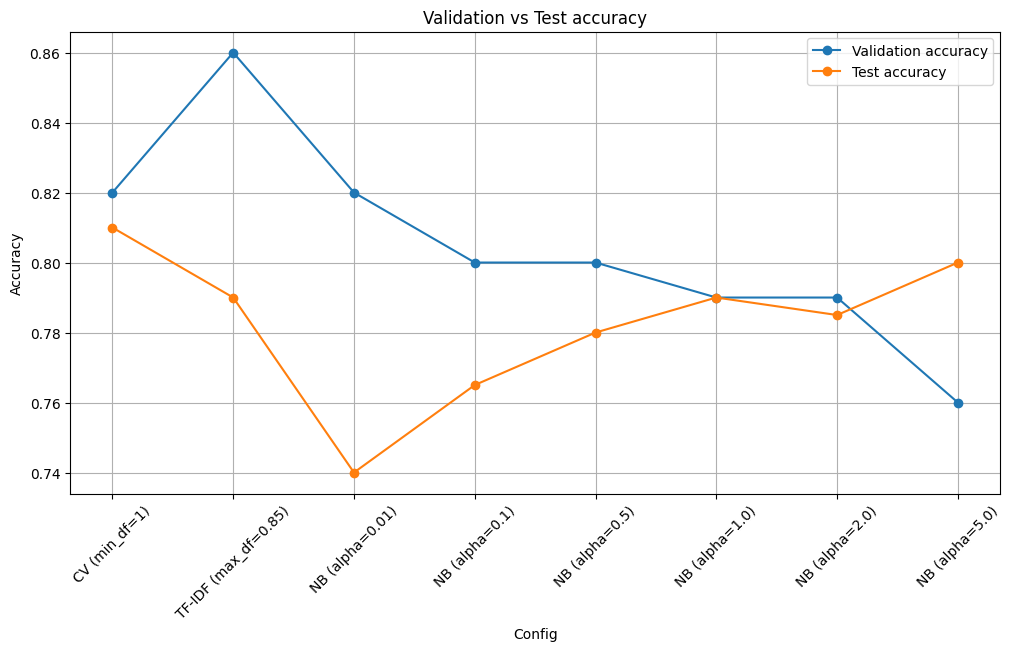

In [41]:
configs = [
    'CV (min_df=1)',
    'TF-IDF (max_df=0.85)',
    'NB (alpha=0.01)',
    'NB (alpha=0.1)',
    'NB (alpha=0.5)',
    'NB (alpha=1.0)',
    'NB (alpha=2.0)',
    'NB (alpha=5.0)'
]

val_accuracies = [0.820, 0.860, 0.820, 0.800, 0.800, 0.790, 0.790, 0.760]
test_accuracies = [0.810, 0.790, 0.740, 0.765, 0.780, 0.790, 0.785, 0.800]

plt.figure(figsize=(12, 6))
plt.plot(configs, val_accuracies, marker='o', label='Validation accuracy')
plt.plot(configs, test_accuracies, marker='o', label='Test accuracy')
plt.xlabel('Config')
plt.ylabel('Accuracy')
plt.title('Validation vs Test accuracy')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()